# Compound report Generation

This takes each compound from our top 100 for Alzhemier's Disease identified in the previous step, and then
for each endpoint (also definied in the previous step) determines which genes have the most influence. It also produces a separate file for non-gene concepts that have the most influcence (not currently used).

In [27]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import utils
from data_tools import graphs as gt

In [2]:
n, e = utils.load_network()

In [3]:
id_to_name = n.set_index('id')['name'].to_dict()

In [4]:
c = gt.combine_nodes_and_edges(n, e)

In [5]:
alz_id = 'DOID:10652'

In [6]:
def find_subname(substr, label=None):
    if label is not None:
        nodes = n.query('label == @label')
    else:
        nodes = n
    return nodes[nodes['name'].str.lower().str.contains(substr.lower())]

In [7]:
data_param = utils.load_params()

In [8]:
data_dir = Path('../2_pipeline/AD_Endpoints/out/').resolve()

probas = pd.read_csv(data_dir.joinpath('top_100_probas.csv'))
probas.head(2)

,chemicalsubstance_id,disease_id,status,proba,cid,did,treat_proba,dementia_proba,apraxia_proba,abnormality_of_mitochondrial_metabolism_proba,...,negative_regulation_of_neuroinflammatory_response_proba,protein_import_into_mitochondrial_matrix_proba,mini_excitatory_postsynaptic_potential_proba,evoked_excitatory_postsynaptic_potential_proba,negative_regulation_of_astrocyte_activation_proba,neuroinflammatory_response_proba,stress-induced_mitochondrial_fusion_proba,positive_regulation_of_nmda_glutamate_receptor_activity_proba,tau-protein_kinase_activity_proba,astrocyte_activation_involved_in_immune_response_proba
0,CHEBI:8354,DOID:10652,0,0.777562,pralidoxime,Alzheimer's disease,1.000000,1.000000,0.038108,0.894264,...,0.068867,0.000000,0.107494,0.090951,0.016399,0.040318,0.000000,0.050407,0.198083,0.058200
1,CHEBI:8892,DOID:10652,0,0.741301,rosiglitazone maleate,Alzheimer's disease,0.916298,0.590014,0.166400,0.060238,...,0.652547,0.437979,0.579645,0.676068,0.508406,0.667096,0.046816,0.469879,0.567980,0.468558


In [9]:
top_100_comp = probas['chemicalsubstance_id'].tolist()

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
gene_counts = c.query('start_id in @top_100_comp and end_label == "MacromolecularMachine"').drop_duplicates(subset=['end_id'])['start_name'].value_counts()

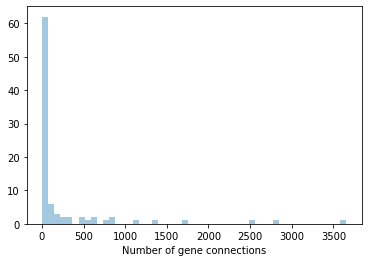

In [12]:
sns.distplot(gene_counts, kde=False)
plt.xlabel('Number of gene connections');

In [13]:
gene_counts.head(20)

Dietary Fats                         3657
Tobacco Smoke Pollution              2848
benzo[a]pyrene                       2559
2,4,5,2',4',5'-hexachlorobiphenyl    1703
ammonium chloride                    1325
hydroxyzine hydrochloride            1115
cadmium dichloride                    850
Lipopolysaccharides                   842
copper(II) sulfate                    747
cyclosporin A                         619
diarsenic trioxide                    587
doxorubicin                           519
Cu2+                                  488
sodium arsenite                       467
Dichlorodiphenyl Dichloroethylene     327
valproic acid                         300
dexamethasone                         277
17beta-estradiol                      233
ethynodiol diacetate                  212
Tetrachlorodibenzodioxin              165
Name: start_name, dtype: int64

In [14]:
gene_counts.tail(20)

linoleic acid                                                                            5
edrophonium                                                                              5
potassium chloride                                                                       5
N-methyl-3-phenyl-3-[4-(trifluoromethyl)phenoxy]propan-1-amine                           5
brucine                                                                                  5
phorbol 13-acetate 12-myristate                                                          5
SB 203580                                                                                4
aluminium trichloride                                                                    4
(R)-noradrenaline                                                                        4
(R,R)-tramadol                                                                           4
methylene blue                                                                           4

In [15]:
low_gene = gene_counts.tail(10).sample(1, random_state=0).index[0]
low_gene = n.query('name == @low_gene')['id'].tolist()[0]

In [16]:
high_gene = gene_counts.head(10).sample(1, random_state=1).index[0]
high_gene = n.query('name == @high_gene')['id'].tolist()[0]

# Start with High Gene

In [17]:
from plot_utils import MFGPathPlotter

In [18]:
high_gene

'CHEBI:29865'

In [19]:
id_to_name[high_gene]

'benzo[a]pyrene'

In [20]:
endpoints = utils.read_json(data_dir.joinpath('endpoints.json'))
endpoints

{'increase_bp': ['GO:0006914',
  'GO:0061909',
  'GO:0000422',
  'GO:0006119',
  'GO:0150079',
  'GO:0030150',
  'GO:0098816',
  'GO:0098817',
  'GO:0061889'],
 'decrease_bp': ['GO:0150076',
  'GO:1990046',
  'GO:1904783',
  'GO:0050321',
  'GO:0002265'],
 'phenotypes': ['HP:0003287',
  'HP:0002185',
  'HP:0002120',
  'HP:0002354',
  'HP:0002423',
  'HP:0002446'],
 'diseases': ['DOID:1307', 'DOID:0060135']}

In [21]:
param_map = {
    'increase_bp': 'CaBP_param.json',
    'decrease_bp': 'CiBP_param.json',
    'phenotypes': 'CtP_param.json',
    'diseases': 'data_param.json'
}

#### Initialize the feature extractor

In [22]:
mgp = MFGPathPlotter()

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:55<00:00,  1.24it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:26<00:00,  2.54it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 127.95it/s]


#### Get all paths for a given drug-endpoint pair

In [23]:
param_dir = Path('../0_data/manual/').resolve()

## Skipping from here to end, as none of this is saved

In [25]:
dc = dict() # data container

for effect, targets in endpoints.items():
    # Set the proper parameters
    param = param_map[effect]
    mgp.set_params(param_dir.joinpath(param))
    
    inner_dc = dict()  # Inner data container
    
    for tgt in targets:
        paths = mgp.get_path_info(high_gene, tgt)
        
        try:
            ranks = mgp.rank_connecting_nodes(paths)
        except:
            ranks = float('nan')
        
        inner_dc[tgt] = {'paths': paths, 'ranks': ranks}
    
    dc[effect] = inner_dc

100%|██████████| 25/25 [05:51<00:00, 14.07s/it]


KeyboardInterrupt: 

In [ ]:
for k, v in dc.items():
    for k1, v1 in v.items():
        print(k, k1, '{:,}'.format(len(v1['paths'])))

### Do something with the paths

In [ ]:
v1['ranks']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [ ]:
gene_result = []
query_txt = 'deg_sep == 1 and node_label == "MacromolecularMachine"'

for effect, values in dc.items():
    for tgt, v1 in values.items():
        
        tgt_name = id_to_name[tgt].lower().replace(' ', '_')
        
        genes = v1['ranks'].query(query_txt).copy()
        genes[tgt_name+'_scaled_metric'] = mm.fit_transform(genes['model_metric'].values.reshape(-1, 1))
        gene_result.append(genes.set_index('node_id')[[tgt_name+'_scaled_metric']])

        
gene_result = pd.concat(gene_result, axis=1)

In [ ]:
val_cols = gene_result.columns
gene_result = gene_result.reset_index().rename(columns={'index': 'node_id'})
gene_result['mean'] = gene_result[val_cols].mean(axis=1)
gene_result['total'] = gene_result[val_cols].T.count()
gene_result['zero_fill_mean'] = gene_result[val_cols].fillna(0).mean(axis=1)
gene_result['node_name'] = gene_result['node_id'].map(id_to_name)

In [ ]:
len(val_cols)

In [ ]:
gene_result.sort_values('mean', ascending=False).head(30)

In [ ]:
gene_result.sort_values('zero_fill_mean', ascending=False).head(30)

In [ ]:
gene_result.query('total >= 8')

In [ ]:
sns.heatmap(gene_result.sort_values('zero_fill_mean', ascending=False).set_index('node_name').head(15)[val_cols]);

In [ ]:
sns.heatmap(gene_result.sort_values('zero_fill_mean', ascending=False).set_index('node_name')[val_cols]);

In [ ]:
from collections import defaultdict

In [ ]:
test_gene = "NCBIGene:54209"
tgt_results = defaultdict(list)

for effect, values in dc.items():
    for tgt, v1 in values.items():
        tgt_results[effect].append(mgp.query_path_node(v1['paths'], test_gene))

In [ ]:
first = list(tgt_results.keys())[0]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results[first][0])

In [ ]:
first = list(tgt_results.keys())[1]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results[first][2])

In [ ]:
first = list(tgt_results.keys())[2]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results[first][2])

In [ ]:
first = list(tgt_results.keys())[3]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results[first][0])

In [ ]:
first = list(tgt_results.keys())[3]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results[first][1])

In [ ]:
v1['paths']

In [ ]:
other_result = []
query_txt = 'deg_sep != 1 or node_label != "MacromolecularMachine"'

for effect, values in dc.items():
    for tgt, v1 in values.items():
        
        tgt_name = id_to_name[tgt].lower().replace(' ', '_')
        others = v1['ranks'].query(query_txt).copy()
        
        try:
            others[tgt_name+'_scaled_metric'] = mm.fit_transform(others['model_metric'].values.reshape(-1, 1))
        except ValueError: 
            others[tgt_name+'_scaled_metric'] = float('nan')

        other_result.append(others.set_index('node_id')[[tgt_name+'_scaled_metric']])

        
other_result = pd.concat(other_result, axis=1)

In [ ]:
val_cols = other_result.columns
other_result = other_result.reset_index().rename(columns={'index': 'node_id'})
other_result['mean'] = other_result[val_cols].mean(axis=1)
other_result['total'] = other_result[val_cols].T.count()
other_result['zero_fill_mean'] = other_result[val_cols].fillna(0).mean(axis=1)
other_result['node_name'] = other_result['node_id'].map(id_to_name)

In [ ]:
other_result.sort_values('mean', ascending=False).head(30)

In [ ]:
other_result.sort_values('zero_fill_mean', ascending=False).head(30)

In [ ]:
other_result.sort_values(['total', 'mean'], ascending=False).head(30)

In [ ]:
other_result.sort_values('autophagy_scaled_metric', ascending=False).head(30)

In [ ]:
test_node = "GO:0004497"
tgt_results1 = defaultdict(list)

for effect, values in dc.items():
    for tgt, v1 in values.items():
        tgt_results1[effect].append(mgp.query_path_node(v1['paths'], test_node))

In [ ]:
first = list(tgt_results1.keys())[0]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results1[first][0])

In [ ]:
first = list(tgt_results1.keys())[3]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results1[first][0])

In [ ]:
first = list(tgt_results1.keys())[3]
mgp.set_params(param_dir.joinpath(param_map[first]))
mgp.draw_top_paths(tgt_results1[first][1])

# Low degree compound

In [ ]:
dc1 = dict() # data container

for effect, targets in endpoints.items():
    # Set the proper parameters
    param = param_map[effect]
    mgp.set_params(param_dir.joinpath(param))
    
    inner_dc1 = dict()  # Inner data container
    
    for tgt in targets:
        paths = mgp.get_path_info(low_gene, tgt)
        
        try:
            ranks = mgp.rank_connecting_nodes(paths)
        except:
            ranks = float('nan')
        
        inner_dc1[tgt] = {'paths': paths, 'ranks': ranks}
    
    dc1[effect] = inner_dc1

In [ ]:
for k, v in dc1.items():
    for k1, v1 in v.items():
        try:
            print(k, id_to_name[k1], '{:,}'.format(len(v1['paths'])))
        except:
            print(k, id_to_name[k1], '{:,}'.format(0))


In [ ]:
pd.DataFrame({'test': list()})

In [ ]:
gene_result1 = []
query_txt = 'deg_sep == 1 and node_label == "MacromolecularMachine"'

for effect, values in dc1.items():
    for tgt, v1 in values.items():
        
        tgt_name = id_to_name[tgt].lower().replace(' ', '_')
        
        try:
            others = v1['ranks'].query(query_txt).copy()
            others[tgt_name+'_scaled_metric'] = mm.fit_transform(others['model_metric'].values.reshape(-1, 1))
        except ValueError: 
            others[tgt_name+'_scaled_metric'] = float('nan')
        except AttributeError:
            others = pd.DataFrame({tgt_name+'_scaled_metric': list(), 'node_id': list()})

        gene_result1.append(others.set_index('node_id')[[tgt_name+'_scaled_metric']])

        
gene_result1 = pd.concat(gene_result1, axis=1)

In [ ]:
val_cols = gene_result1.columns
gene_result1 = gene_result1.reset_index().rename(columns={'index': 'node_id'})
gene_result1['mean'] = gene_result1[val_cols].mean(axis=1)
gene_result1['total'] = gene_result1[val_cols].T.count()
gene_result1['zero_fill_mean'] = gene_result1[val_cols].fillna(0).mean(axis=1)
gene_result1['node_name'] = gene_result1['node_id'].map(id_to_name)

In [ ]:
gene_result1.sort_values('mean', ascending=False)

In [ ]:
sns.heatmap(gene_result1.sort_values('mean', ascending=False).set_index('node_name')[val_cols]);

# Try on all 

In [24]:
def rank_nodes_across_endpoints(dc, genes=True, scale=True):
    gene_result = []
    
    if genes:
        query_txt = 'deg_sep == 1 and node_label == "MacromolecularMachine"'
    else:
        query_txt = 'deg_sep != 1 or node_label != "MacromolecularMachine"'

    sel_col = '_scaled_metric' if scale else '_metric'
        
    for effect, values in dc.items():
        for tgt, v1 in values.items():

            tgt_name = id_to_name[tgt].lower().replace(' ', '_')

            try:
                others = v1['ranks'].query(query_txt).copy()
                if scale:
                    others[tgt_name+sel_col] = mm.fit_transform(others['model_metric'].values.reshape(-1, 1))
                else:
                    others[tgt_name+sel_col] = others['model_metric'].values
            except ValueError: 
                others[tgt_name+sel_col] = float('nan')
            except AttributeError:
                others = pd.DataFrame({tgt_name+sel_col: list(), 'node_id': list()})

            gene_result.append(others.set_index('node_id')[[tgt_name+sel_col]])


    gene_result = pd.concat(gene_result, axis=1)

    val_cols = gene_result.columns
    gene_result = gene_result.reset_index().rename(columns={'index': 'node_id'})
    gene_result['mean'] = gene_result[val_cols].mean(axis=1)
    gene_result['total'] = gene_result[val_cols].T.count()
    gene_result['zero_fill_mean'] = gene_result[val_cols].fillna(0).mean(axis=1)
    gene_result['node_name'] = gene_result['node_id'].map(id_to_name)
    
    gene_result = gene_result.sort_values('mean', ascending=False).reset_index(drop=True)
    
    return gene_result[['node_id', 'node_name', 'mean', 'total', 'zero_fill_mean']+val_cols.tolist()]


In [ ]:
rank_nodes_across_endpoints(dc1, True, False)

In [25]:
out_dir = Path('../2_pipeline').resolve().joinpath('Compound_report_generation', 'out')
out_dir.mkdir(exist_ok=True, parents=True)

## Get paths

In [ ]:
dc['increase_bp']['GO:0006914']['paths']

In [ ]:
pc_res = defaultdict(list)

for drug in top_100_comp:
    
    drug_name = id_to_name[drug].lower().replace(' ', '_')
    dc = dict() # data container

    pc_res['drug'].append(drug)
    pc_res['drug_name'].append(drug_name)
    
    for effect, targets in endpoints.items():
        # Set the proper parameters
        param = param_map[effect]
        mgp.set_params(param_dir.joinpath(param))

        inner_dc = dict()  # Inner data container

        # Get the Paths
        for tgt in targets:
            paths = mgp.get_path_info(drug, tgt)

            try:
                ranks = mgp.rank_connecting_nodes(paths)
            except:
                ranks = float('nan')

            inner_dc[tgt] = {'paths': paths, 'ranks': ranks}

        dc[effect] = inner_dc
        
        
    # Get top concepts and save
    gene_res = rank_nodes_across_endpoints(dc, True, False)
    gene_res.to_csv(out_dir.joinpath(drug_name+'_tgt_genes.csv'), index=False)
    
    other_res = rank_nodes_across_endpoints(dc, False, False)
    other_res.to_csv(out_dir.joinpath(drug_name+'_concepts.csv'), index=False)
    
    for k, v in dc.items():
        for k1, v1 in v.items():
            pc_res[k1].append(len(v1['paths']) if type(v1['paths']) == pd.DataFrame else 0)
        
pd.DataFrame(pc_res).to_csv(out_dir.joinpath('total_path_count.csv'), index=False)

100%|██████████| 25/25 [00:05<00:00,  4.29it/s]


 92%|█████████▏| 23/25 [00:18<00:04,  2.31s/it]